In [505]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *

In [506]:
def locallization(B):
    W = np.zeros([40,40])
    L = 10
    
    for i in range(40):
        for j in range(40):
            d_i = np.mod(np.abs(i+40-j),40)
            d_j = np.mod(np.abs(j+40-i),40)
            d = np.min([d_i,d_j])
            W[i,j] = np.exp(-1*d**2/2/L**2)

    return np.multiply(W,B)

In [532]:
nT = 800
nk = 20
#set random seed
np.random.seed(201910)

#load true value
x_t_save = np.genfromtxt('x_t.txt')

# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
analysis_error = 25.e-2
#load background error covariance matrix
B = np.genfromtxt('B.txt')

np.random.seed(20191031)
# create observations

observation_error = 25.e-2
y_o_save = np.zeros([nT+1, N])
y_o_save = x_t_save + observation_error * np.random.randn(nT+1, N)

# initial x_b: no values at the initial time (assign NaN)
x_b_save = np.array([x_a_init])

# initial x_a: from x_a_ens_init

x_a_save = np.array([x_a_init])
print("x_a_save shape = ",x_a_save.shape)

tt = 0
R = 0.25 * np.identity(40) #observation error covariance

B_temp_2 = B.copy()
B_a = np.reshape(B_temp_2,[40,40,1])
B_f = np.reshape(B_temp_2,[40,40,1])
H = np.identity(40)

while tt <= nT:
    ttf = tt + 1
    Ta = tt  * dT  # forecast start time(DA time)
    Tf = ttf * dT  # forecast end time
    print('Cycle =', tt, ', Ta =', round(Ta, 10), ', Tf =', round(Tf, 10))
    # background
    if tt ==0:
        B = B.copy()
        K_i = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B,H))+R)))
        K = np.reshape(K_i, [1,40,40])
    else:
        k_i = np.split(K,ttf)[tt]
    for e in range(nk):
        #--------------
        # analysis step
        #--------------
        x_b = x_b_save[tt].transpose()
        # observation
        y_o = y_o_save[tt].transpose()
        #perturb observation
        np.random.seed(20191130+e)
        y_o_k = y_o + observation_error * np.random.randn(N)
        
        # innovation
        y_b = np.dot(H, x_b)
        d = y_o_k - y_b
        x_a = x_b + np.dot(K_i,d)
        if e == 0:
            x_a_k_save = np.reshape(x_a.transpose(),[1,40])
        else:
            #print()
            x_a_k_save = np.vstack([x_a_k_save, np.reshape(x_a,[1,40])])
        #--------------
        # forecast step
        #--------------
        np.random.seed(20181130+e+2*tt)
        #print(x_a_k_save[tt].shape)
        solver = ode(lorenz96.f).set_integrator('dopri5')
        #print(np.trace(PH))
        P_a = 0.12 
        #P_a = 0.12
        solver.set_initial_value(x_a.transpose() + P_a * np.random.randn(N), Ta).set_f_params(F)
        solver.integrate(Tf)
        if e == 0:
            x_b_k_save = np.array([solver.y])
        else:
            x_b_k_save = np.vstack([x_b_k_save, [solver.y]])

    x_a_k_mean = np.mean(x_a_k_save, axis = 0)
    x_b_k_mean = np.mean(x_b_k_save, axis = 0)
    x_b_save = np.vstack([x_b_save,x_b_k_mean])
    x_a_save = np.vstack([x_a_save, x_a_k_mean])
    #do the poll
    
    PH = np.cov(x_b_k_save,rowvar = False)
    HPH = np.cov(x_b_k_save,rowvar = False)
    
    #print(np.trace(PH))
    K_ip1 = np.dot(locallization(PH), np.linalg.inv(locallization(HPH)+R))
    K = np.concatenate((K, np.reshape(K_ip1,[1,40,40])), axis =0)
    print(np.trace(PH))
    tt += 1

#save background and analysis data

x_b_save = x_b_save[0:801][:]
x_a_save = x_a_save[1:802][:]

#np.savetxt('x_b_k200_l10_modelerror0.08.txt', x_b_save)
#np.savetxt('x_a_k200_l10_modelerror0.08.txt', x_a_save)

x_a_save shape =  (1, 40)
Cycle = 0 , Ta = 0.0 , Tf = 0.05
0.7344934428984051
Cycle = 1 , Ta = 0.05 , Tf = 0.1
0.7978254265073668
Cycle = 2 , Ta = 0.1 , Tf = 0.15
0.6803068776732921
Cycle = 3 , Ta = 0.15 , Tf = 0.2
0.7703946556944998
Cycle = 4 , Ta = 0.2 , Tf = 0.25
0.7438140025306202
Cycle = 5 , Ta = 0.25 , Tf = 0.3
0.6665230501217356
Cycle = 6 , Ta = 0.3 , Tf = 0.35
0.7626482185953567
Cycle = 7 , Ta = 0.35 , Tf = 0.4
0.6416101575552422
Cycle = 8 , Ta = 0.4 , Tf = 0.45
0.7674647979065635
Cycle = 9 , Ta = 0.45 , Tf = 0.5
0.7018390999455879
Cycle = 10 , Ta = 0.5 , Tf = 0.55
0.7038748527944688
Cycle = 11 , Ta = 0.55 , Tf = 0.6
0.7290467050633005
Cycle = 12 , Ta = 0.6 , Tf = 0.65
0.7382095925540222
Cycle = 13 , Ta = 0.65 , Tf = 0.7
0.7283299002003751
Cycle = 14 , Ta = 0.7 , Tf = 0.75
0.6674470723080913
Cycle = 15 , Ta = 0.75 , Tf = 0.8
0.7414850964986489
Cycle = 16 , Ta = 0.8 , Tf = 0.85
0.737598396901072
Cycle = 17 , Ta = 0.85 , Tf = 0.9
0.6914974046688387
Cycle = 18 , Ta = 0.9 , Tf = 0.

0.6917770076081038
Cycle = 154 , Ta = 7.7 , Tf = 7.75
0.7559640842858617
Cycle = 155 , Ta = 7.75 , Tf = 7.8
0.7101163499293783
Cycle = 156 , Ta = 7.8 , Tf = 7.85
0.7466830438058285
Cycle = 157 , Ta = 7.85 , Tf = 7.9
0.6916169748015883
Cycle = 158 , Ta = 7.9 , Tf = 7.95
0.7095812073654546
Cycle = 159 , Ta = 7.95 , Tf = 8.0
0.6932481863473399
Cycle = 160 , Ta = 8.0 , Tf = 8.05
0.720192468899904
Cycle = 161 , Ta = 8.05 , Tf = 8.1
0.7611240779557276
Cycle = 162 , Ta = 8.1 , Tf = 8.15
0.7270739307173422
Cycle = 163 , Ta = 8.15 , Tf = 8.2
0.658362116472393
Cycle = 164 , Ta = 8.2 , Tf = 8.25
0.7855559652349811
Cycle = 165 , Ta = 8.25 , Tf = 8.3
0.7390006365306037
Cycle = 166 , Ta = 8.3 , Tf = 8.35
0.7526433655493909
Cycle = 167 , Ta = 8.35 , Tf = 8.4
0.7426595069953851
Cycle = 168 , Ta = 8.4 , Tf = 8.45
0.7098070134849883
Cycle = 169 , Ta = 8.45 , Tf = 8.5
0.7149666724035021
Cycle = 170 , Ta = 8.5 , Tf = 8.55
0.7066593608619778
Cycle = 171 , Ta = 8.55 , Tf = 8.6
0.8141908720619906
Cycle = 172

0.7769318282367894
Cycle = 303 , Ta = 15.15 , Tf = 15.2
0.7266372824009775
Cycle = 304 , Ta = 15.2 , Tf = 15.25
0.8030679998440806
Cycle = 305 , Ta = 15.25 , Tf = 15.3
0.7817256421484724
Cycle = 306 , Ta = 15.3 , Tf = 15.35
0.7394735562788686
Cycle = 307 , Ta = 15.35 , Tf = 15.4
0.7453254153238159
Cycle = 308 , Ta = 15.4 , Tf = 15.45
0.6883915142178423
Cycle = 309 , Ta = 15.45 , Tf = 15.5
0.6994957333001393
Cycle = 310 , Ta = 15.5 , Tf = 15.55
0.7571750134474742
Cycle = 311 , Ta = 15.55 , Tf = 15.6
0.6969868117603544
Cycle = 312 , Ta = 15.6 , Tf = 15.65
0.7263838763039909
Cycle = 313 , Ta = 15.65 , Tf = 15.7
0.732212817228153
Cycle = 314 , Ta = 15.7 , Tf = 15.75
0.6734331026137697
Cycle = 315 , Ta = 15.75 , Tf = 15.8
0.7280475099853811
Cycle = 316 , Ta = 15.8 , Tf = 15.85
0.7063146198671306
Cycle = 317 , Ta = 15.85 , Tf = 15.9
0.6930950029536167
Cycle = 318 , Ta = 15.9 , Tf = 15.95
0.6656612118101523
Cycle = 319 , Ta = 15.95 , Tf = 16.0
0.7242750294635663
Cycle = 320 , Ta = 16.0 , Tf =

0.7237616144901452
Cycle = 451 , Ta = 22.55 , Tf = 22.6
0.6728566813204531
Cycle = 452 , Ta = 22.6 , Tf = 22.65
0.6994515266845971
Cycle = 453 , Ta = 22.65 , Tf = 22.7
0.695724906930244
Cycle = 454 , Ta = 22.7 , Tf = 22.75
0.7375593406700494
Cycle = 455 , Ta = 22.75 , Tf = 22.8
0.6600860472605299
Cycle = 456 , Ta = 22.8 , Tf = 22.85
0.7479843335614212
Cycle = 457 , Ta = 22.85 , Tf = 22.9
0.7559301635931575
Cycle = 458 , Ta = 22.9 , Tf = 22.95
0.7245154404661298
Cycle = 459 , Ta = 22.95 , Tf = 23.0
0.7349138662640196
Cycle = 460 , Ta = 23.0 , Tf = 23.05
0.7261295403434282
Cycle = 461 , Ta = 23.05 , Tf = 23.1
0.721028941481173
Cycle = 462 , Ta = 23.1 , Tf = 23.15
0.7064890403317006
Cycle = 463 , Ta = 23.15 , Tf = 23.2
0.733680502348818
Cycle = 464 , Ta = 23.2 , Tf = 23.25
0.7242733560351766
Cycle = 465 , Ta = 23.25 , Tf = 23.3
0.6863632121627554
Cycle = 466 , Ta = 23.3 , Tf = 23.35
0.6601248187504446
Cycle = 467 , Ta = 23.35 , Tf = 23.4
0.7373837771558177
Cycle = 468 , Ta = 23.4 , Tf = 2

0.7063383040973028
Cycle = 600 , Ta = 30.0 , Tf = 30.05
0.7608126393847862
Cycle = 601 , Ta = 30.05 , Tf = 30.1
0.7721007712283772
Cycle = 602 , Ta = 30.1 , Tf = 30.15
0.7494185741331636
Cycle = 603 , Ta = 30.15 , Tf = 30.2
0.7656520986584963
Cycle = 604 , Ta = 30.2 , Tf = 30.25
0.7481895757850985
Cycle = 605 , Ta = 30.25 , Tf = 30.3
0.8054083875028359
Cycle = 606 , Ta = 30.3 , Tf = 30.35
0.7438689367954585
Cycle = 607 , Ta = 30.35 , Tf = 30.4
0.7331472025705608
Cycle = 608 , Ta = 30.4 , Tf = 30.45
0.7607541254355528
Cycle = 609 , Ta = 30.45 , Tf = 30.5
0.7092890195673445
Cycle = 610 , Ta = 30.5 , Tf = 30.55
0.7372277290125994
Cycle = 611 , Ta = 30.55 , Tf = 30.6
0.685780721185316
Cycle = 612 , Ta = 30.6 , Tf = 30.65
0.7108142307574461
Cycle = 613 , Ta = 30.65 , Tf = 30.7
0.6741512882231915
Cycle = 614 , Ta = 30.7 , Tf = 30.75
0.72928223794776
Cycle = 615 , Ta = 30.75 , Tf = 30.8
0.6635981164935542
Cycle = 616 , Ta = 30.8 , Tf = 30.85
0.6788297378294768
Cycle = 617 , Ta = 30.85 , Tf = 

0.7533779433886547
Cycle = 748 , Ta = 37.4 , Tf = 37.45
0.7254965944144571
Cycle = 749 , Ta = 37.45 , Tf = 37.5
0.7003628679197985
Cycle = 750 , Ta = 37.5 , Tf = 37.55
0.6883204322084264
Cycle = 751 , Ta = 37.55 , Tf = 37.6
0.781948158204111
Cycle = 752 , Ta = 37.6 , Tf = 37.65
0.7371074583262591
Cycle = 753 , Ta = 37.65 , Tf = 37.7
0.7506899409848422
Cycle = 754 , Ta = 37.7 , Tf = 37.75
0.7632347630848837
Cycle = 755 , Ta = 37.75 , Tf = 37.8
0.7329702693709048
Cycle = 756 , Ta = 37.8 , Tf = 37.85
0.731239024769698
Cycle = 757 , Ta = 37.85 , Tf = 37.9
0.656226597362032
Cycle = 758 , Ta = 37.9 , Tf = 37.95
0.7388329125530189
Cycle = 759 , Ta = 37.95 , Tf = 38.0
0.7186273825005836
Cycle = 760 , Ta = 38.0 , Tf = 38.05
0.7571283207535879
Cycle = 761 , Ta = 38.05 , Tf = 38.1
0.6476627749797318
Cycle = 762 , Ta = 38.1 , Tf = 38.15
0.709978210705962
Cycle = 763 , Ta = 38.15 , Tf = 38.2
0.7220620075076274
Cycle = 764 , Ta = 38.2 , Tf = 38.25
0.704711014346281
Cycle = 765 , Ta = 38.25 , Tf = 38

In [533]:
bias_v = []
rmse_v = []
for i in range(N):
    pt = i
    #plt.figure()
    #print(x_a_save[:,pt-1])
    #print(x_b_save[:,pt-1])
    
    #plt.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$')
    #plt.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
    #plt.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'bo-' , label=r'$x^a_{' + str(pt) + '}$')
    bias_i = (x_b_save[30:,pt-1]-x_t_save[30:,pt-1]).mean()
    #print("bias = ", bias_i)
    rmse_i = np.std(x_b_save[30:,pt-1]-x_t_save[30:,pt-1])
    #print("rmse = ", rmse_i)
    bias_v.append(bias_i)
    rmse_v.append(rmse_i)
    
    #plt.xlabel(r'$t$', size=18)
    #plt.ylabel(r'$x$', size=18)
    #plt.xlim(0,3)
    #plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
    #plt.legend(loc='upper right', numpoints=1, prop={'size':18})
    #plt.savefig('timeseries.png', dpi=200)
    #plt.show()
    #plt.close()
print("bias=", np.mean(bias_v))
print("rmse=", np.mean(rmse))

bias= 0.0038885379676047702
rmse= 0.16019369289368476


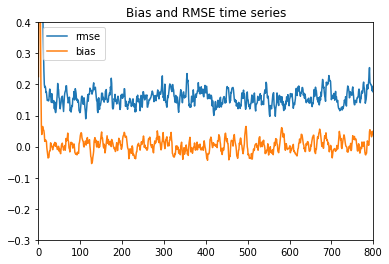

rmse= 0.15699946778246418
bias= 0.0038419817085592386


In [534]:
analysis_error = x_b_save-x_t_save
bias_t = []
rmse_t = []
for i in range(nT):
    
    bias_i = analysis_error[i][:].mean()
    rmse_i = np.std(analysis_error[i][:])
    bias_t = np.append(bias_t, bias_i)
    rmse_t = np.append(rmse_t, rmse_i)


plt.plot(rmse_t, label ="rmse" )
plt.plot(bias_t, label ="bias")
plt.ylim(-0.3,0.4)
plt.xlim(0,800)
plt.legend(loc="upper left")
plt.title("Bias and RMSE time series")
plt.show()
rmse = rmse_t[30:800].mean()
bias = bias_t[30:800].mean()
print("rmse=",rmse)
print("bias=",bias)
#np.savetxt('ENKF_k200_l10_modelerror0.08_bias.txt',bias_t)
#np.savetxt('ENKF_k200_l10_modelerror0.08_rmse.txt',rmse_t)

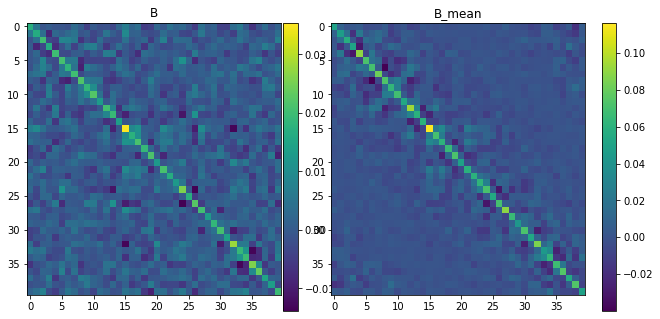

In [443]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.08, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('B_mean')
plt.imshow(np.reshape(k_i,[40,40]))
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.08, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

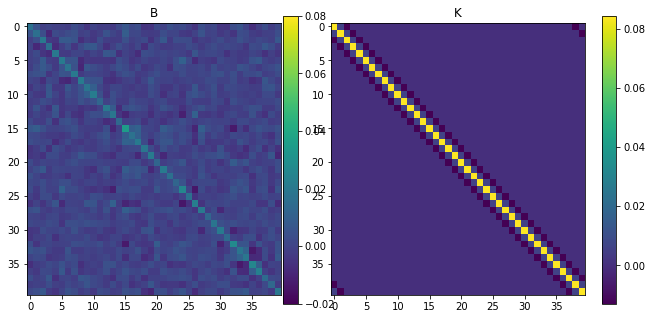

In [444]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH,vmin=-0.02,vmax=0.08)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('K')
plt.imshow(B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

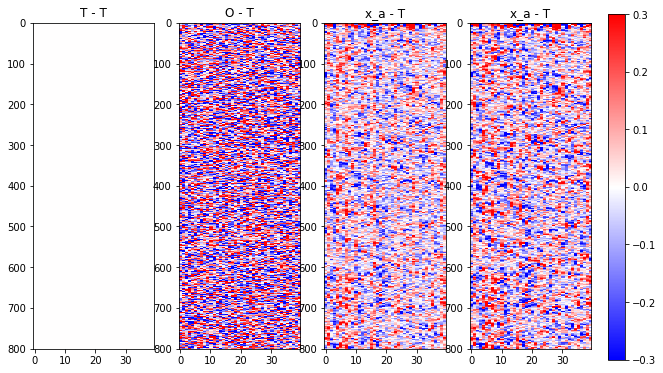

In [520]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(141)
ax.set_title('T - T')
plt.imshow(x_t_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax.set_aspect('auto')

ax2 = fig.add_subplot(142)
ax2.set_title('O - T')
plt.imshow(y_o_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax2.set_aspect('auto')


ax3 = fig.add_subplot(143)
ax3.set_title('x_a - T')
plt.imshow(x_a_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax3.set_aspect('auto')


ax4 = fig.add_subplot(144)
ax4.set_title('x_a - T')
plt.imshow(x_b_save[0:801][:]-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax4.set_aspect('auto')


cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [446]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(0, 40), ylim=(0, 40))

ax.set_title('B')
ax.set_aspect('auto')

#line, = ax.plot([], [], lw=2)
a = np.random.random((40,40))
im = plt.imshow(a,interpolation='none', vmin=-0.02, vmax =0.06)
# initialization function: plot the background of each frame
def init():
    im.set_data(np.random.random((40,40)))
           
    cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    
    return [im]

# animation function.  This is called sequentially
def animate(i):

    a = np.reshape(np.split(K,ttf+1)[i], [40,40])
    im.set_array(a)

    return [im]

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


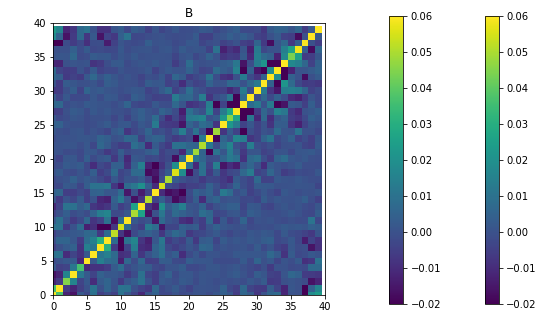

In [447]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=10, blit=True)
anim.save('basic_animation.mp4', fps=12, extra_args=['-vcodec', 'libx264'])
plt.show()